# Rossman Competition
This exercise aims to develop a neural network to predic sales of Rossman stores for 6 weeks. I will use data provided by Kaggle's Rossman challenge (https://www.kaggle.com/c/rossmann-store-sales). Important things learnt from this exercise include application of neural networks to structure data, and utilizing embedding matrices for categorical variables. I will follow codes given in fast.ai, and fast.ai study group material provided at https://github.com/dlnerds/dlnerds 

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
# pip install fastai
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossmann/'

## Data Cleaning and Feature Engineering
Fast.ai's Jeremy goes over lot of data cleaning and feature engineering steps in the fast.ai notebook. Even though data preprocessing is crucial in any machine learning model, since my main focus is on deep learning, I will just use his codes and quickly jump to the deep learning part.

Feature Space:

* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [5]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

Use pandas to load all the given tables in to a list of dataframes. Then take a look at those by displaying the headers.

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [7]:
from IPython.display import HTML

In [8]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [10]:
len(train),len(test)

(1017209, 41088)

Jeremy's Data cleaning and feature engineering steps are performed below:

In [11]:
# Convert state Holidays to booleans
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

# A function to perform pandas join
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

# Join weather/state names
weather = join_df(weather, state_names, "file", "StateName")

# Add googletrend by date and state
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

# Extracting date/time fields for constructing categoricals
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

# Taking googletrend data - germany as a whole
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

Aside: Why note just do an inner join? If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [12]:
store = join_df(store, store_states, "Store")
print( len(store[store.State.isnull()]) )

joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
print( len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()]) )

joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
print( len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()]) )

joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
print( len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()]) )

joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
print( len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()]) )

0
0 0
0 0
0 0
0 0


In [13]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [14]:
# Pick arbitrary signal values for missing values in these cases
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)
    
# Extract features "CompetitionOpenSince" and "CompetitionDaysOpen"
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

# Replace some erroneous / outlying data
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

# Add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
print( joined.CompetitionMonthsOpen.unique() )

# Same process for Promo dates
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

[24  3 19  9  0 16 17  7 15 22 11 13  2 23 12  4 10  1 14 20  8 18  6 21  5]


In [15]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

In [16]:
# define a function get_elapsed for cumulative counting across a sorted dataframe. 
# Given a particular field fld to monitor, this function will start tracking time since 
#the last occurrence of that field. When the field is seen again, the counter is set to zero

def get_elapsed(df,fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res
    return df

# define a function to easily apply the same set of operations for both test and train    
def add_durations( df, joinedDF ):
    fld = 'SchoolHoliday'
    df = df.sort_values(['Store', 'Date'])
    df = get_elapsed(df, fld, 'After')
    df = df.sort_values(['Store', 'Date'], ascending=[True, False])
    df = get_elapsed(df, fld, 'Before')
    
    fld = 'StateHoliday'
    df = df.sort_values(['Store', 'Date'])
    df = get_elapsed(df, fld, 'After')
    df = df.sort_values(['Store', 'Date'], ascending=[True, False])
    df = get_elapsed(df, fld, 'Before')
    
    fld = 'Promo'
    df = df.sort_values(['Store', 'Date'])
    df = get_elapsed(df, fld, 'After')
    df = df.sort_values(['Store', 'Date'], ascending=[True, False])
    df = get_elapsed(df, fld, 'Before')
    
    # set the active index to Date
    df = df.set_index("Date")
    
    # set null values from elapsed field calculations to 0
    columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

    for o in ['Before', 'After']:
        for p in columns:
            a = o+p
            df[a] = df[a].fillna(0).astype(int)
    
    # window functions in pandas to calculate rolling quantities
    bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
    fwd = df[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
    
    # drop the Store indices grouped together in the window function
    bwd.drop('Store',1,inplace=True)
    bwd.reset_index(inplace=True)

    fwd.drop('Store',1,inplace=True)
    fwd.reset_index(inplace=True)
    
    df.reset_index(inplace=True)
    
    df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
    df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
    
    df.drop(columns,1,inplace=True)
    
    df["Date"] = pd.to_datetime(df.Date)
    
    finalDF = join_df(joinedDF, df, ['Store', 'Date'])
    
    return finalDF

In [17]:
# applying the above function to a subset of columns
columns_new = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [18]:
joined = add_durations( train[columns_new], joined )
joined_test = add_durations( test[columns_new], joined_test )

In [19]:
joined = joined[joined.Sales!=0]

In [20]:
# Backup
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

### Create Features

In [21]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [22]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


Convert input into a compatible form with neural network

In [23]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [24]:
dep = 'Sales' # dependent variable
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [25]:
# Make a column for dependent variable in test
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

Change categorical data columns into categories identified by the neural network

In [26]:
??apply_cats # is a function to convert strings of categorical variables to codes

In [27]:
def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

In [28]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [29]:
apply_cats(joined_test, joined)

Pytorch wants the continous values to be in Float32

In [30]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

Do the final preprocessing steps: Replace NAs by median, and add a new column to indicate NA rows, and numericalize the whole data frame.

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from pandas.api.types import is_string_dtype, is_numeric_dtype

We use just a subset as a sample. Later we will use the full set of data

In [34]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

In [32]:
??proc_df

process data frame function:
1. Pulls out the dependent variable, puts it into a separate variable, and deletes it from the original data frame. In other words, df do not have `Sales` column, and `y` only contains `Sales` column.
2. `do_scale` : Neural nets really like to have the input data to all be somewhere around zero with a standard deviation of somewhere around 1. So we take our data, subtract the mean, and divide by the standard deviation to make that happen. It returns a special object which keeps track of what mean and standard deviation it used for that normalization so you can do the same to the test set later (`mapper`).
3. It also handles missing values — for categorical variable, it becomes ID: 0 and other categories become 1, 2, 3, and so on. For continuous variable, it replaces the missing value with the median and create a new boolean column that says whether it was missing or not.

In [35]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [36]:
joined_test = joined_test.set_index("Date")

In [37]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

Taking a random set of validation data is not ideal for time series data. I will take the final 25% of data sorted by date as the validation set.

In [38]:
train_ratio = 0.75
train_size = int(samp_size * train_ratio); print(train_size)
val_idx = list(range(train_size, len(df)))

112500


We create a model data object below, which has a validation set, training set, and optional test set built into it. Unlike image recognition data, where these data sets can be read-in by directory structure, here we use `ColumnarDataset` class and get data from our data frame.

In [39]:
((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idx, df, yl.astype(np.float32))

In [57]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y, is_reg=True, is_multi=False):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = (np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1)))
        self.conts = (np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1)))
        self.y = (np.zeros((n,1)) if y is None else y)
        if is_reg:
            self.y =  self.y[:,None]
        self.is_reg = is_reg
        self.is_multi = is_multi

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None, is_reg=True, is_multi=False):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y, is_reg, is_multi)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None, is_reg=True, is_multi=False):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y, is_reg, is_multi)

In [58]:
column_datasets = {'train': ColumnarDataset.from_data_frame(trn_df, cat_vars, trn_y),
                   'val': ColumnarDataset.from_data_frame(val_df, cat_vars, val_y)}

In [59]:
len(column_datasets['train'].y)

112500

In [60]:
column_dataloaders = {x: torch.utils.data.DataLoader(column_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

In [61]:
len(column_dataloaders['train'])

879

## Embedding

Using embedding matrices for categorical variables enables the neural network to identify patterns between classes within a given categorical variable. Moreover, it will be computationally faster and less memory consuming compared to one-hot-encoding.

In [46]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

Jeremy's rule of thumb for the size of the embediing matrix is to use the minimum of the cardinality+1 and 50

In [47]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [48]:
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

We will pass these embedding sizes to the learner

## Deep Learning Model

Our model will contain an embedding layer with dropout, a fully connected linear layer followed by a ReLu, another linear layer, then a softmax.

For Rossman challenge, the metric used to judge the performance is Root Mean Square Percentage Error (RMSPE)

In [49]:
def inv_y(a): return np.exp(a)
def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [50]:
y_range

(0, 12.63454087942548)

The Plan:
* We started by creating model data object which has a validation set, training set, and optional test set built into it. From that, we will get a `learner`, we will then optionally call `lr_find`, then train the model (call `learn.fit` in fast.ai) and so forth.
* In image recognition, we can use path and directory structure to divide the data in to training, and validation sets. However, in structure data we use `columanarDataSet` class and load data from data frame.
* We defined the embedding matrices for our categorical variables.
* Feed the aforementioned standard model data object into the `learner`.

The Model:

In [51]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = F.sigmoid(x)
            else:
                x = F.log_softmax(x)
        elif self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
    
    def inv_y(self,a): return np.exp(a)

    def exp_rmspe(self,y_pred, targ):
        targ = self.inv_y(targ.cpu().data)
        pct_var = (targ - self.inv_y(y_pred.cpu().data))/targ
        return math.sqrt((pct_var**2).mean())

    def calculate_loss(self, outputs, targets, **kwargs):
        return F.mse_loss(input=outputs, target=targets)
        
    def calculate_metrics(self, outputs, targets, **kwargs):
        classification_accuracy = 1-self.exp_rmspe(outputs,targets)
        return classification_accuracy

In [52]:
model = MixedInputModel(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

Description:
* `emb_szs` : sizes of embedding matrices
* `len(df.columns)-len(cat_vars)` : number of continuous variables
* `0.04` : how much dropout to use in embedding layer
* `1` : output size
* `[1000,500]` : how many activations to have in each layer
* `[0.001,0.01]` : how many dropout to use at later layers

Use Adam as the optimizer

In [53]:
optimizer_col= optim.Adam(model.parameters(),lr=0.001)

In [67]:
# train_col = train.Trainer(m~odel,column_dataloaders['train'],column_dataloaders['val'],optimizer_col)
# the above command returned an error about Trainer because I didn't want to import the custom library dllib
# So decided to use the fast.ai columnar data loader instead
# Use fast.ai columnar data loader
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128, 
                                  test_df=df_test)

Fast.ai `get_learner` builds a MixedInputModel for us

In [71]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

Learning rate survey:

In [72]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 66%|██████▌   | 581/879 [00:30<00:15, 19.36it/s, loss=0.683]

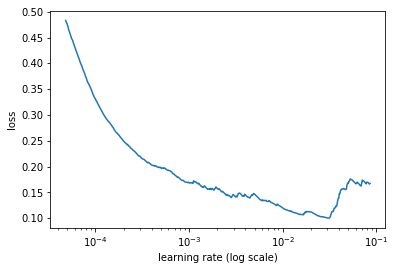

In [73]:
m.sched.plot(100)

We choose a learning rate in the region just before the loss started to increase. Infact in this case, `1e-3` value we used would work fine

Trying different learning rates and SGDR parameters (explained below)

In [78]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                    
    0      0.028962   0.023813   0.163325  
    1      0.020587   0.018138   0.146005                     
    2      0.017494   0.018654   0.135527                     


[array([0.01865]), 0.13552661511774422]

In [79]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                    
    0      0.015849   0.014832   0.126409  
    1      0.014067   0.012542   0.119138                     
    2      0.010901   0.011309   0.111057                     
    3      0.009359   0.010918   0.109776                      
    4      0.013122   0.013338   0.119559                     
    5      0.010449   0.011476   0.11436                      
    6      0.008599   0.010789   0.108697                      
    7      0.007803   0.010351   0.106819                      


[array([0.01035]), 0.10681856252429324]

### Stochastic Gradient Descent with Restarts
We've used a technique called stochastic gradient descent with restarts (SGDR), a variant of learning rate annealing, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"): <img src="./data/learning_images/SGDR.png">
(From the paper [Snapshot Ensembles](https://arxiv.org/pdf/1704.00109.pdf)).

The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is refered to as the number of cycles, and is what we're actually passing as the 2nd parameter to fit(). So here's what our actual learning rates looked like:

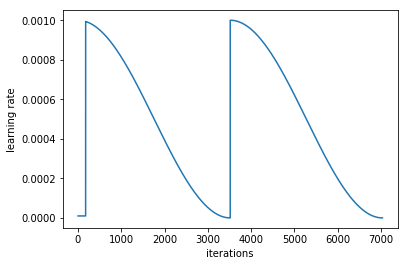

In [81]:
m.sched.plot_lr()

### Train all:
Since we now performed learning rate finder to determine the optimal parameters, we will now use all the data.

In [85]:
samp_size = n
joined_samp = joined.set_index("Date")

In [86]:
len(joined_samp)

844338

In [87]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [88]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); print(train_size)
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

633253


In [89]:
((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idx, df, yl.astype(np.float32))

In [90]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128, 
                                  test_df=df_test)

In [91]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [92]:
m.fit(lr, 1, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.014368   0.020363   0.131199  


[array([0.02036]), 0.1311989278763488]

In [93]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.011016   0.013891   0.112283  
    1      0.0093     0.01356    0.110362                        
    2      0.008994   0.013076   0.108532                        


[array([0.01308]), 0.10853249288017815]

In [94]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.006908   0.011916   0.102187  
    1      0.006924   0.011808   0.101475                        
    2      0.006774   0.011602   0.101375                        


[array([0.0116]), 0.10137538797671516]

In [96]:
m.save('val0')

In [97]:
m.load('val0')

In [98]:
x,y=m.predict_with_targs()

In [99]:
exp_rmspe(x,y)

0.1056749042159721

In [100]:
pred_test=m.predict(True)

In [101]:
pred_test = np.exp(pred_test)

In [102]:
joined_test['Sales']=pred_test

In [107]:
model

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(1116, 50)
    (1): Embedding(8, 4)
    (2): Embedding(4, 2)
    (3): Embedding(13, 7)
    (4): Embedding(32, 16)
    (5): Embedding(3, 2)
    (6): Embedding(26, 13)
    (7): Embedding(27, 14)
    (8): Embedding(5, 3)
    (9): Embedding(4, 2)
    (10): Embedding(4, 2)
    (11): Embedding(24, 12)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 27)
    (15): Embedding(22, 11)
    (16): Embedding(7, 4)
    (17): Embedding(7, 4)
    (18): Embedding(4, 2)
    (19): Embedding(4, 2)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
  )
  (lins): ModuleList(
    (0): Linear(in_features=217, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_dro

## Comparison to Random Forest

In [103]:
from sklearn.ensemble import RandomForestRegressor

In [104]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [105]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [106]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.9821290849380468,
 0.9319712460889528,
 0.9241907128768685,
 0.10859555196861052)